# Implementing Deep Neural Networks for YouTube Recommendations in PyTorch

---



[Deep Neural Networks for YouTube Recommendations](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf), published in 2016 by Paul Covington, Jay Adams and Emre Sargin, has a great impact on the development of recommendation system. The system has two major components: candidate generation and ranking. 

In this tutorial, I implement the candidate generation system. As YouTube does not release its data, I use MovieLens data set to model it.

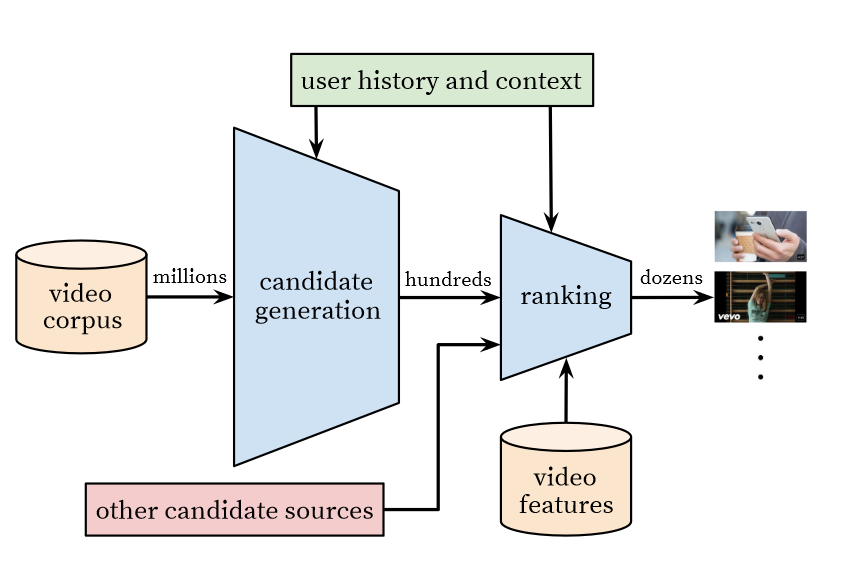

In [3]:
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')

import torch
assert '.'.join(torch.__version__.split('.')[:2]) == '1.8'
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Import data set.

Download the MovieLens data set from its official website. It contains three data sets: *Ratings*, *Users*, *Movies*.

In [4]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

In [5]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', engine='python', header = None, names  = ['user_id','movie_id','rating','timestamp'])
users = pd.read_csv('ml-1m/users.dat', sep = '::', engine='python', header = None, names  = ['user_id', 'gender', 'age', 'occupation', 'zip_code'])
movies = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python', header = None, names=['movie_id', 'title', 'genres'])

The data sets have 1 million ratings rated by 6,000 users on 3,800 movies between 2000-04-25 and 2003-02-28. Let's take a look at the data sets.

In [6]:
print('Ratings:')
print(ratings.head(2))

Ratings:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109


In [7]:
print('Users:')
print(users.head(2))

Users:
   user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072


In [8]:
print('Movies:')
print(movies.head(2))


Movies:
   movie_id             title                        genres
0         1  Toy Story (1995)   Animation|Children's|Comedy
1         2    Jumanji (1995)  Adventure|Children's|Fantasy


The candidate generation component is illustrated as below:
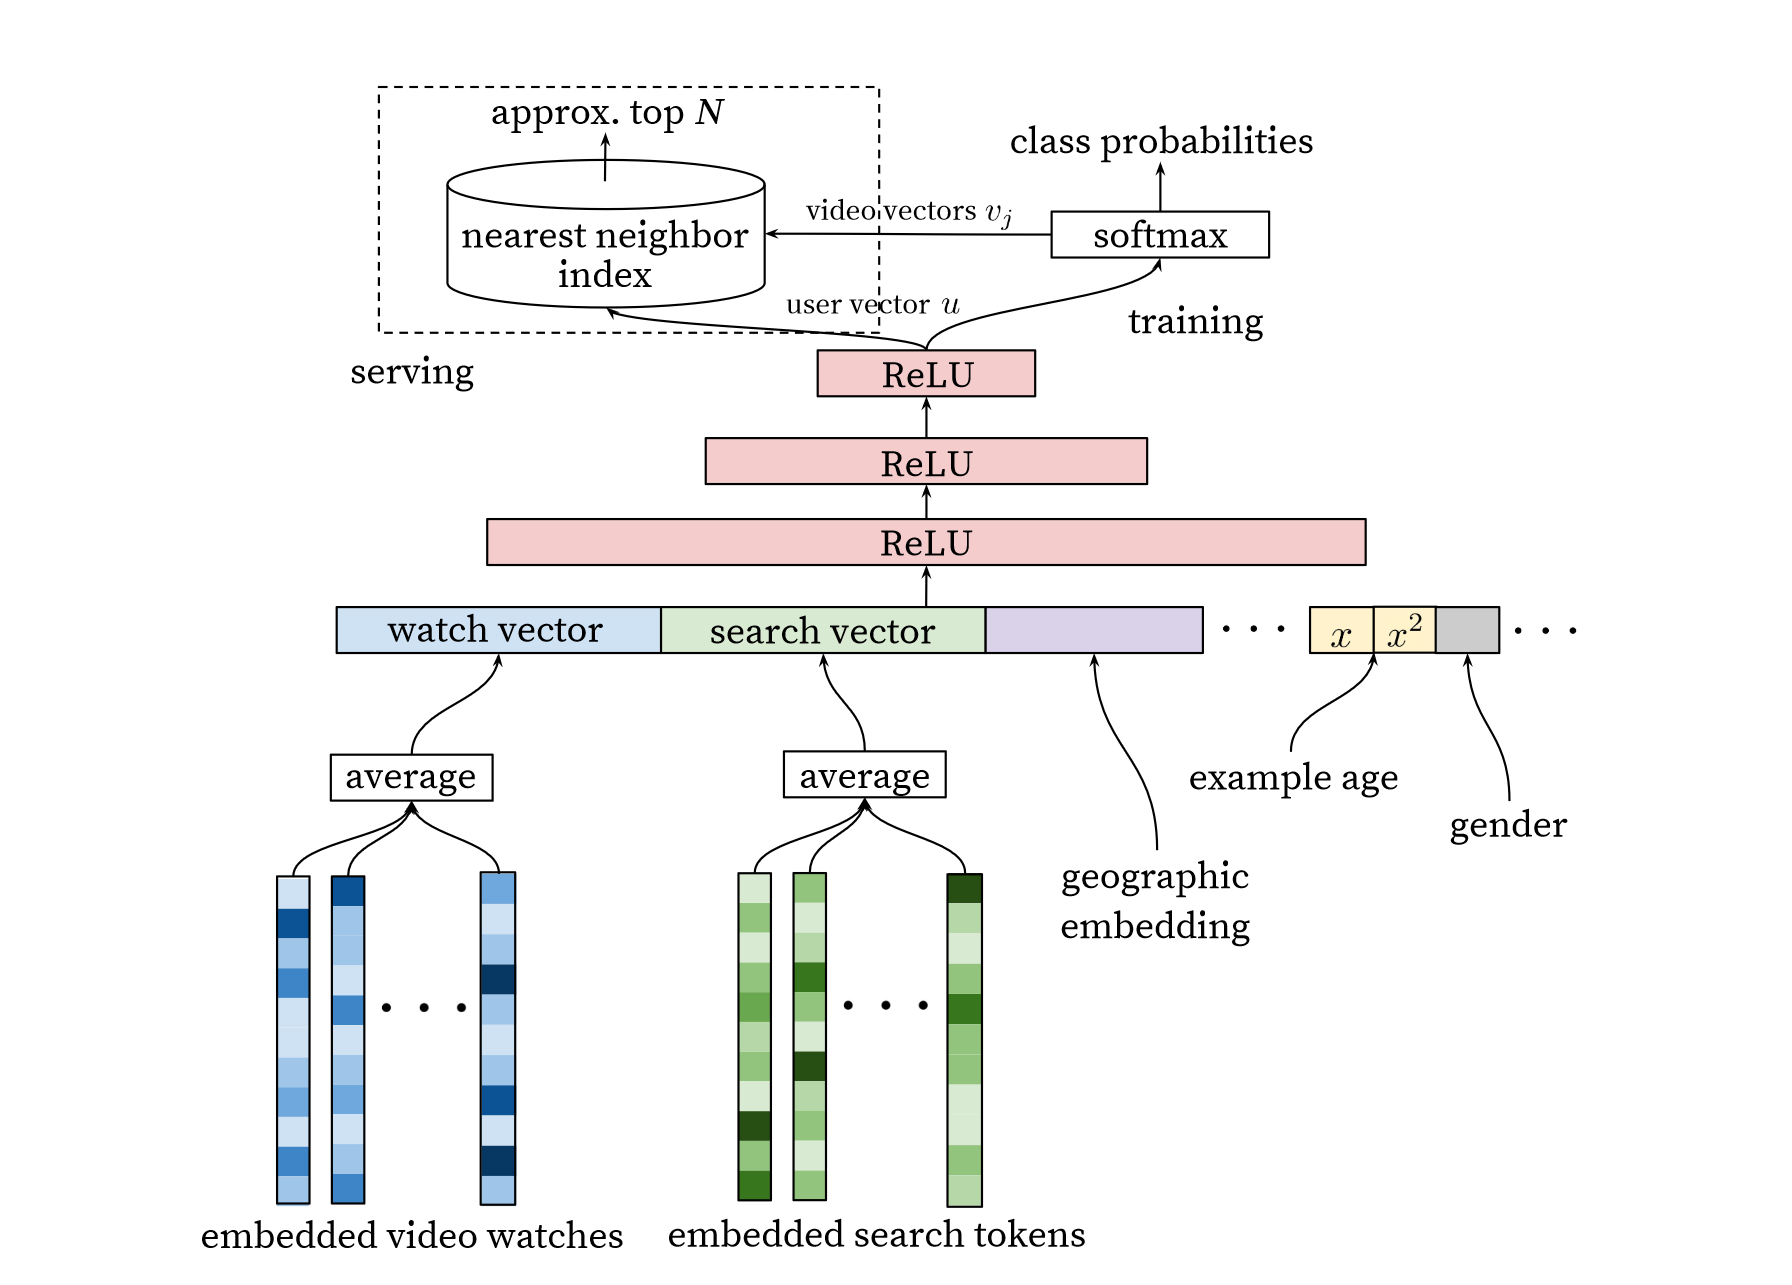



The YouTube paper uses video watches, search history, and user context (such as gender) to train the model. Note that Youtube does not use explicit rating because it is extremely sparse. Instead, it uses the implicit feedback of watches, where a user completing a video is a positive example. I model the input information of the NN model as follows:

*   Video watches: I use the rating pairs in the *Ratings* data set as evidences that the user has completed the video. The movies rated by a user in the *Ratings* data set are considered as the user's video watches. 

*   Search history: The title of a completed movie is taken as the search tokens for that user.

*   User context: the information provided in the *Users* data set, namely gender, age and occupation, are used as context variables. 

Example age is in fact an important feature in the YouTube model. Recommending  recently  uploaded content is extremely important for YouTube because users prefer fresh content. However, given that the rating time in the data set was between 2000-04-25 23:05:32 and 2003-02-28 17:49:50, which is a relatively short period, while the movies' production time varies across a long period. It is not sensible to model the example age using this data set.

# 2. Data Preprocessing.

##2.1 Search tokens.

[GloVe](https://nlp.stanford.edu/projects/glove/) works better than many other pre-trained word embeddings in a wide range of subsequent NLP tasks. It encodes meaning components in vector differences. Furthermore, it was trained on Wikipedia which is about definitions and explanations of terms, while Google's Word2vec was trained on Google new corpus. The word embedding training model probably learns more from corpus explaining terms than news about who had committed a crime. So it makes sense that GloVe has better performance. 

I use the GloVe pre-trained word embeddings for the search tokens. GloVe pre-trained embeddings come in different dimensions: 50, 100, 200, 300. The number of word embedding dimensions directly affects the number of NN input dimensions. As the number of training examples is not very big, I don't want a huge word embedding dimension. In addition, this is not a pure NLP task. A coarse word embedding is acceptable. Thus, I choose 100 dimensions for this task.  

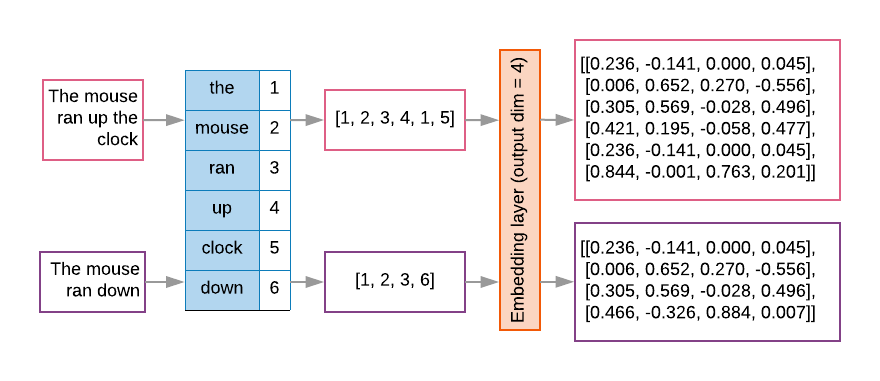

Source: https://developers.google.com/machine-learning/guides/text-classification/images/EmbeddingLayer.png

The word embedding works as follows: 





*   First we create a vocabulary which includes all the words in the search history (movie titles), and assign an integer index for each word. Let's use the above chart to illustrate this process. For example, if the data set has only six words ("the", "mouse", "ran", "up", "clock", "down"), so the vocabulary only has six words, and we assign integers 1-6 as indices for each of them.

*   Then we replace the tokens in the data set with their corresponding indices. For example, one search hisory A "the mouse ran up the" is converted to [1, 2, 3, 4, 1] (here I don't use "the mouse ran up the clock". I set the number of words in the sentence differ from the number of words in the vocabulary to avoid confusion). 

*   Next, we retrieve the pre-trained embedding vectors from GloVe for each word in the vocabulary and hold them in a embedding matrix. This matrix has a shape (number of words in the vocabulary, number of word embedding dimensions) (i.e. shape (6,4) in this example). 

*   The search hisory A [1, 2, 3, 4, 1] is converted to [1_vec, 2_vec, 3_vec, 4_vec, 1_vec] where i_vec is the pre-trained word embedding vector for token i. Now the search history is converted into a matrix of shape (number of words in search history A, number of word embedding dimensions) (i.e. shape (5,4) in this example).

*   At last, we take the average across the words to get a vector whose length is the number of word embedding dimensions (i.e. 4 in this example) as the representation of search hisory A "the mouse ran up the" and feed it into the neural network. Why do we take average? We are seeking a method to reduce the number of input dimensions for the neural network. There could be concatenation methods other than averaging, such as component-wise max, sum, etc. For most tasks, averaging works best, the intuition is that we don't want extreme words dominate the value of search history.

In this way, no matter how long the search history is (for instance, the search history may be like ["Allan Quartermain and the Lost City of Gold", "Amityville 1992: It's About Time", ...], probably has hundreds of search records and each search record has several tokens), we can reduce it to a fixed number of word embedding dimensions (i.e. 100 in this tutorial). Note that only unigram is considered and the Bag of Words assumption is used here.

Let's implement this idea. First, tokenize the movie titles into the "search" column.

In [29]:
def movies_prep(dataset = movies):
  ''' Prepare the movies data set.
  '''

  # the contents of movies.title column includes years. Extract only movie titles to that column.
  dataset['title'] = dataset.title.str.extract(r'(^[^\(]+)')
  # lowercase
  dataset['title'] = dataset['title'].apply(lambda x: x.lower())
  # tokenize
  dataset['search'] = dataset['title'].apply(lambda x: word_tokenize(x))

  return dataset

movies = movies_prep(movies)
print(movies.head(2))

   movie_id       title                        genres        search
0         1  toy story    Animation|Children's|Comedy  [toy, story]
1         2    jumanji   Adventure|Children's|Fantasy     [jumanji]


Second, create a dictionary: *word_to_index* which maps a word in the vocabulary (all the words appeared in movie titles) to an index. Create another dictionary *index_to_word* holds the reverse. Replace the words with their indices in the "search" column.

In [30]:
def mapping(row, word_to_index):
    '''Sub-function used in map_to_id_list(). '''
    
    i = 0
    while i < len(row):
        row[i] = word_to_index[row[i]]
        i += 1
        
    return row
        

def word_map_to_id(dataset, column):
    ''' Convert a dataset.column whose cell is like ['a', 'story'] to [1, 2], where 1, 2 are the index of 'a', 'story' in 
    the constructed dictionary.
    The indices are integers, starting from 1 to the vocabulary size (no 0).
    
    Arguments:
    -- dataset. Name of the dataset.
    -- column name. In string form, e.g. 'user_id'.
    
    Return:
    -- A dictionary mapping {word: index}. 
    -- A dictionary mapping {index: word}.
    -- A modified dataset with the argument column is replaced by the corresponding mapped column.'''
    
    voc_lst = []
    i = 0
    col_index = dataset.columns.get_loc(column)
    while i < dataset.shape[0]:
        voc_lst.extend(dataset.iloc[i, col_index])
        i += 1
        
    voc_set = set(voc_lst)
    word_to_index = {x: i+1 for i, x in enumerate(voc_set)}
    word_to_index['$PAD$'] = 0
    index_to_word = {v: k for k, v in word_to_index.items()}
    
    dataset[column] = dataset[column].apply(lambda x: mapping(x, word_to_index))
    
    return word_to_index, index_to_word, dataset


word_to_index, index_to_word, movies = word_map_to_id(movies, 'search') 

print(movies.head(2))

   movie_id       title                        genres       search
0         1  toy story    Animation|Children's|Comedy  [3276, 901]
1         2    jumanji   Adventure|Children's|Fantasy       [2480]


In [31]:
print(len(index_to_word))

4054


The index_to_word dictionary has 4,054 elements. Index 0 is for padding words and token index start from 1. It is like:


> {0: '$PAD', 1: 'turbo', 2: 'hear', 3: 'robin', ...}

The word_to_index dictionary, the reverse of index_to_word is like:


> {'PAD': 0, 'turbo': 1, 'hear': 2, 'robin': 3, ...}







The length of search tokens (i.e. movie title in this project) varies in each search. However, we need an input of fixed length for the neural network. Thus a cut-off value is set for the max length of search tokens. If the number of tokens in a search is over 8, tokens after the 8th token are truncated. If a search contains less than 8 tokens, zeros are padded at the end (illustrated below, here I refer padding/truncate at the end while the chart refers padding/truncate in front). The search queries are thus represented with an unordered bag of tokens which has fixed length.

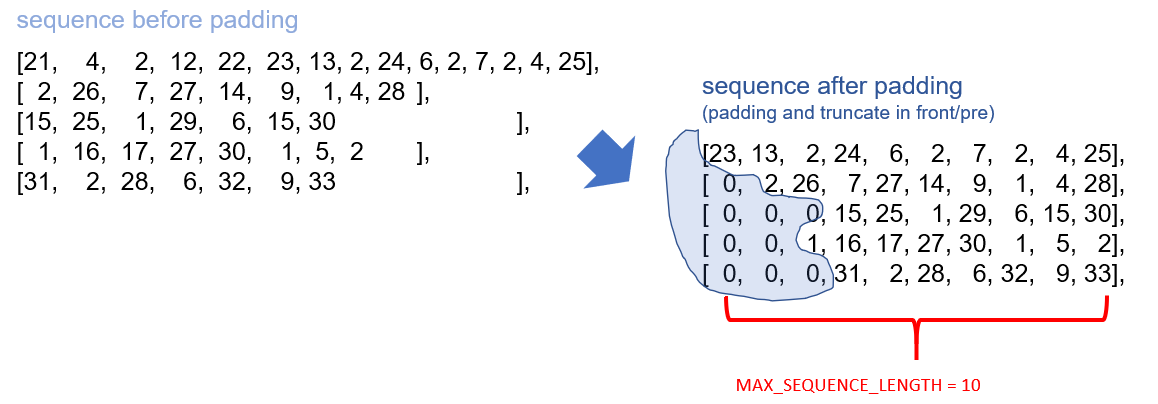
https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633

## 2.2 Creating multiple examples for each user.

The YouTube paper found much betterper formance predicting the user’s next watch, rather than predicting a randomly held-out watch (figure below). I sort the video watches according to the rating time, assuming that the rating time indicates the watch time.

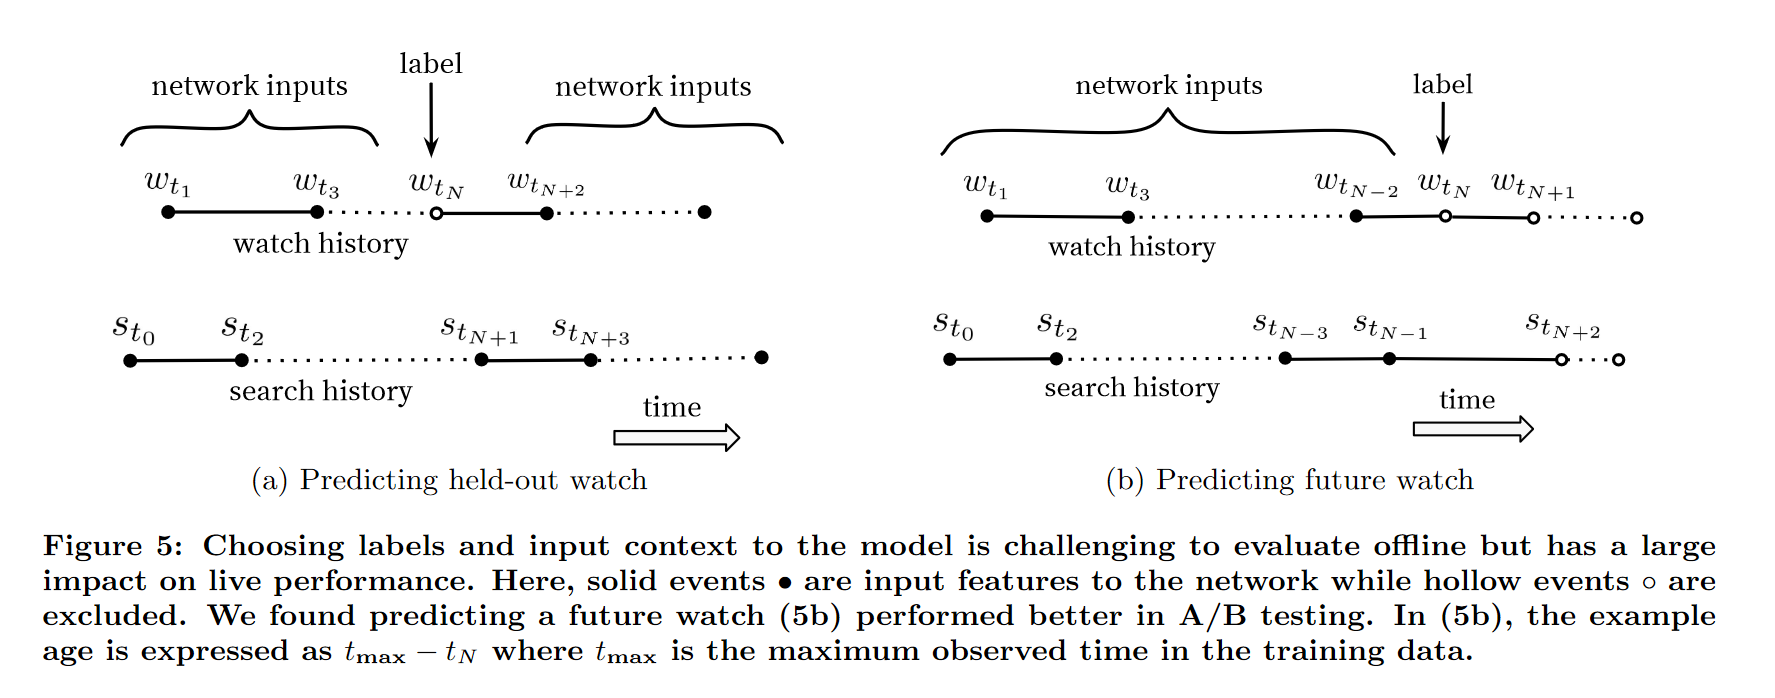

All the users in the data set have watched at least 20 movies, with the number of watched movies varying from 20 to 2,314. However, the paper finds that:

"Another key insight that improved live metrics was to generate a fixed number of training examples per user, effectively weighting our users equally in the loss function. This prevented a small cohort of highly active users from dominating the loss."
 
Therefore, I limit the number of examples per user in the final data set to 10. Also set the length of video watches for each example as 10. That said, only the last 20 movie watches/searches are retained. It is illustrated as below:

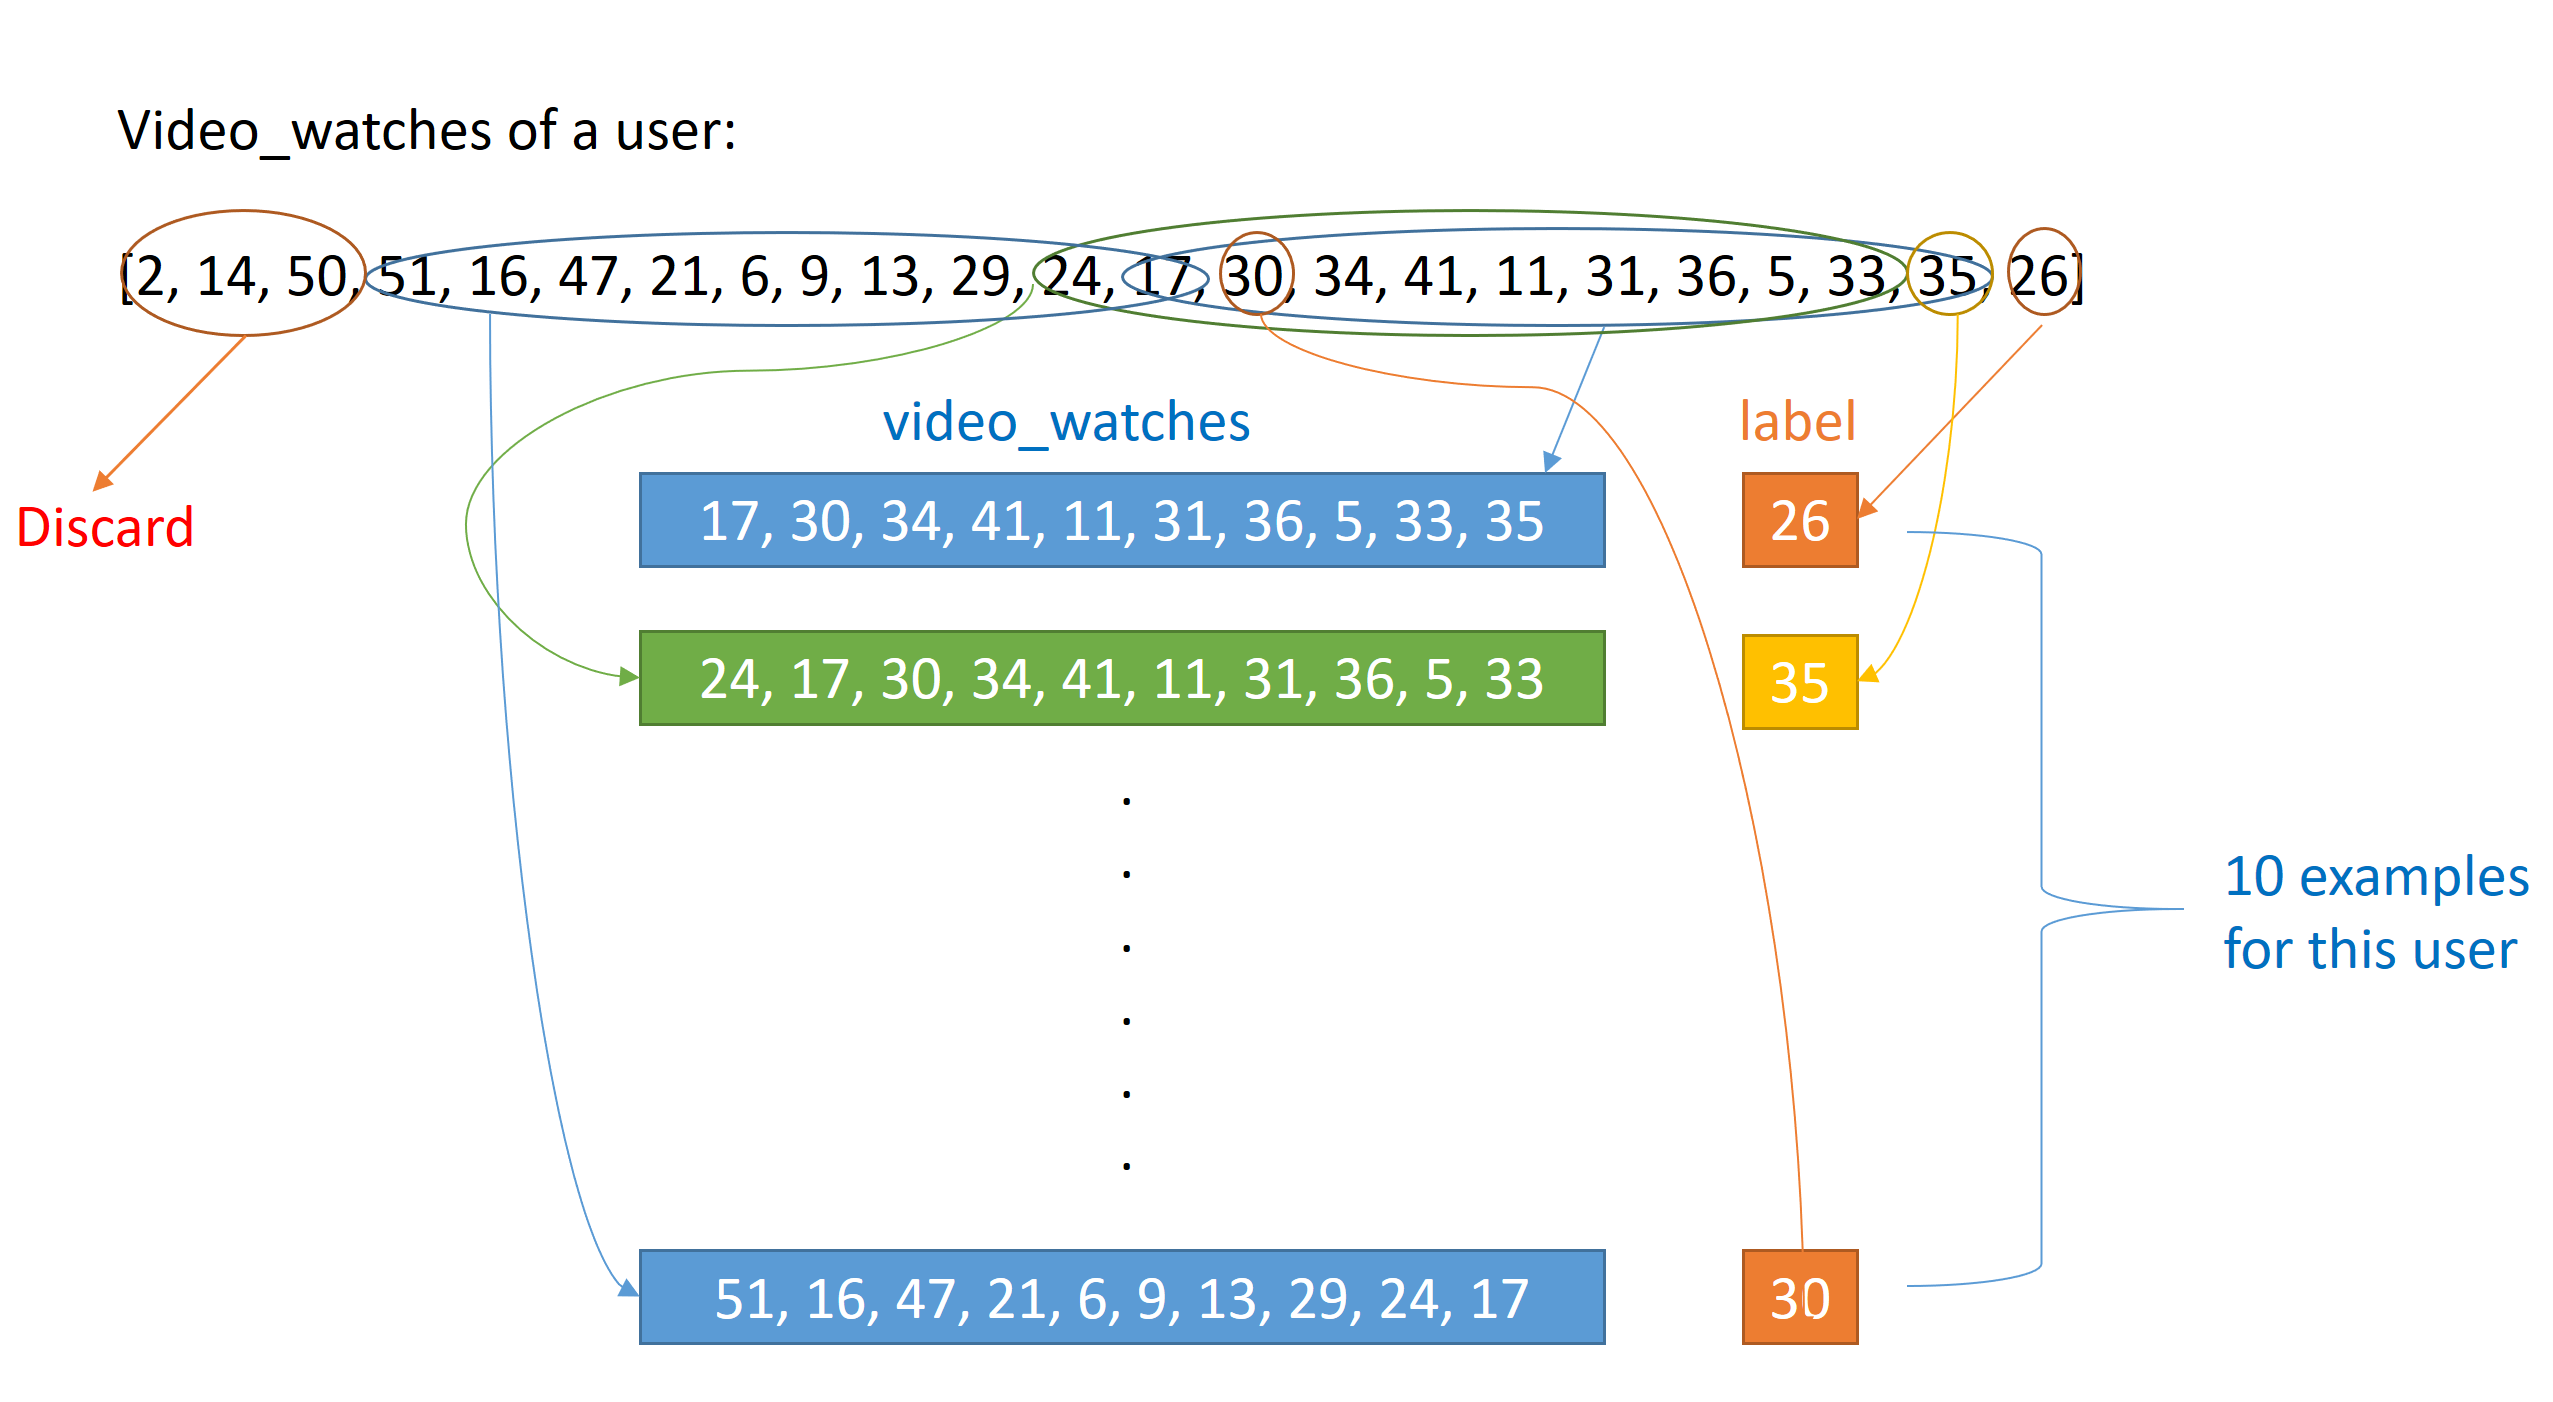
Illustration (created by the author)

## 2.3 Other data preprocessing.

Preprocess *Ratings* data set and merge all three data sets. Apply One Hot 
Encoding to the "gender" and "occupation" columns, and apply standardization (scale to zero mean unit variance) to the "age" column.

Similar to the words in the search history, userID is mapped to index and the index starts from 0. *userID_to_index* and *index_to_userID* hold the mappings between userID and indices. *Index_to_userID* is like:


> {0: 1, 1: 2, 2: 12, 3: 15, ...}, where keys are indices and values are user IDs.

MovieID is also mapped to index and the index starts from 1 (0 is reserved for padding). *movieID_to_index* and *index_to_movieID* hold the mappings between movieID and indices. *Index_to_movieID* is like:


> {0: '$PAD', 1: 1193, 2: 661, 3: 914, ...}, where keys are indices and values are movie IDs.

In [12]:
# preprocess ratings data set and merge all three data sets.
# get two mappings: index & user ID, and index & movie ID.
# create 10 examples for each user, and limit the watch/search history to 10.
# apply One Hot Encoding to the "gender" and "occupation" columns, and standardization to the "age" column.

def user_map_to_id(dataset, column):
  ''' Map distinct values of a dataset.column to consecutive integer ids (From 1, ... to number of distinct values).
  Value 0 for padding.
  
  Arguments:
  -- dataset. Name of the dataset.
  -- column name. In string form, e.g. 'user_id'.
  
  Return:
  -- A dictionary mapping {value: id}. Padding value id is 0.
  -- A dictionary mapping {id: value}. id = 0 for padding value.
  -- A modified dataset with the argument column is replaced by the corresponding mapped column.'''
  
  user_ids = dataset[column].unique().tolist()
  value_to_id = {x: i for i, x in enumerate(user_ids)}
  id_to_value = {v: k for k, v in value_to_id.items()}   
  dataset[column] = dataset[column].map(value_to_id)
  
  return value_to_id, id_to_value, dataset


def movie_map_to_id(dataset, column):
  ''' Map distinct values of a dataset.column to consecutive integer ids (From 1, ... to number of distinct values).
  Value 0 for padding.
  
  Arguments:
  -- dataset. Name of the dataset.
  -- column name. In string form, e.g. 'user_id'.
  
  Return:
  -- A dictionary mapping {value: id}. Padding value id is 0.
  -- A dictionary mapping {id: value}. id = 0 for padding value.
  -- A modified dataset with the argument column is replaced by the corresponding mapped column.'''
  
  user_ids = dataset[column].unique().tolist()
  value_to_id = {x: i+1 for i, x in enumerate(user_ids)}
  value_to_id['$PAD$'] = 0
  id_to_value = {v: k for k, v in value_to_id.items()}   
  dataset[column] = dataset[column].map(value_to_id)
  
  return value_to_id, id_to_value, dataset


def one_hot_encoding(dataset, attr_lst):
  ''' Perform One Hot Encoding on an attribute of a dataset.
  Arguments:
      -- dataset: the data set.
      -- attr_lst: the list of attribute names, in string form. E.g. ['a', 'b']
      
  Output:
      return the dataset with added encoded attributes. And the original attribute is dropped'''
      
  ohc = OneHotEncoder()
  for attr in attr_lst:
      ohe = ohc.fit_transform(dataset[attr].values.reshape(-1,1)).toarray()
      dfOneHot = pd.DataFrame(ohe,columns = [attr + '_' + str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])
      dataset = dataset.join(dfOneHot)
      dataset.drop([attr], axis = 1,inplace=True)
  
  return dataset


def get_groupby_dataset(ratings, users, movies):
    '''
    Get a merged data set where the record of each user is one row.
    '''
    
    # convert ratings.timestamp from timestamp to datetime
    ratings['time'] = pd.to_datetime(ratings['timestamp'], unit='s')  
    
    # merge data sets
    merged = ratings.merge(users, on=['user_id']).merge(movies, on=['movie_id']) 
    
    # map distinct values to id, preparing for the upcoming embedding.
    userID_to_index, index_to_userID, merged = user_map_to_id(merged, 'user_id')
    movieID_to_index, index_to_movieID, merged = movie_map_to_id(merged, 'movie_id')
    
    # create a data set that groupby user_id. Sorted by watch time.
    grouped = merged.sort_values(by = 'time').groupby('user_id').agg({'user_id': 'mean','movie_id': lambda mID: list(mID), 
                                'search': lambda title: list(title), 'gender': 'first',
                                'age': 'mean', 'occupation': 'mean'})

    # set the fixed length of video watches/searches as 10. And create 10 examples for each user.
    for l in range(10):
        grouped['last_but_' + str(l)] = grouped.movie_id.apply(lambda x: x[-(l+1)])
    
    grouped_final = pd.DataFrame()
    for l in range(10):
        temp = grouped.loc[:, ['user_id', 'movie_id', 'search', 'gender', 'age', 'occupation', 'last_but_' + str(l)]]
        temp['movie_id'] = temp['movie_id'].apply(lambda x: x[-(11+l):-(l+1)])
        temp['search'] = temp['search'].apply(lambda x: x[-(11+l):-(l+1)])
        temp = temp.rename(columns={'last_but_' + str(l): 'label', 'movie_id': 'video_watches'})
        grouped_final = grouped_final.append(temp, ignore_index = True)
        
    
    # Do One Hot Encoding for 'gender' and 'occupation'.
    grouped_final = one_hot_encoding(grouped_final, ['gender', 'occupation'])
    
    # Normalize 'age'
    scaler = StandardScaler()
    grouped_final['age'] = scaler.fit_transform(grouped_final['age'].values.reshape(-1,1))
  
    return grouped_final, userID_to_index, index_to_userID, movieID_to_index, index_to_movieID


grouped_final, userID_to_index, index_to_userID, movieID_to_index, index_to_movieID = get_groupby_dataset(ratings, users, movies)

print('Column names:', grouped_final.columns.values)

Column names: ['user_id' 'video_watches' 'search' 'age' 'label' 'gender_F' 'gender_M'
 'occupation_0' 'occupation_1' 'occupation_2' 'occupation_3'
 'occupation_4' 'occupation_5' 'occupation_6' 'occupation_7'
 'occupation_8' 'occupation_9' 'occupation_10' 'occupation_11'
 'occupation_12' 'occupation_13' 'occupation_14' 'occupation_15'
 'occupation_16' 'occupation_17' 'occupation_18' 'occupation_19'
 'occupation_20']


Now the data set looks like this: Each user has ten examples. Each example has ten video watches and ten searches (each search has at most eight tokens).

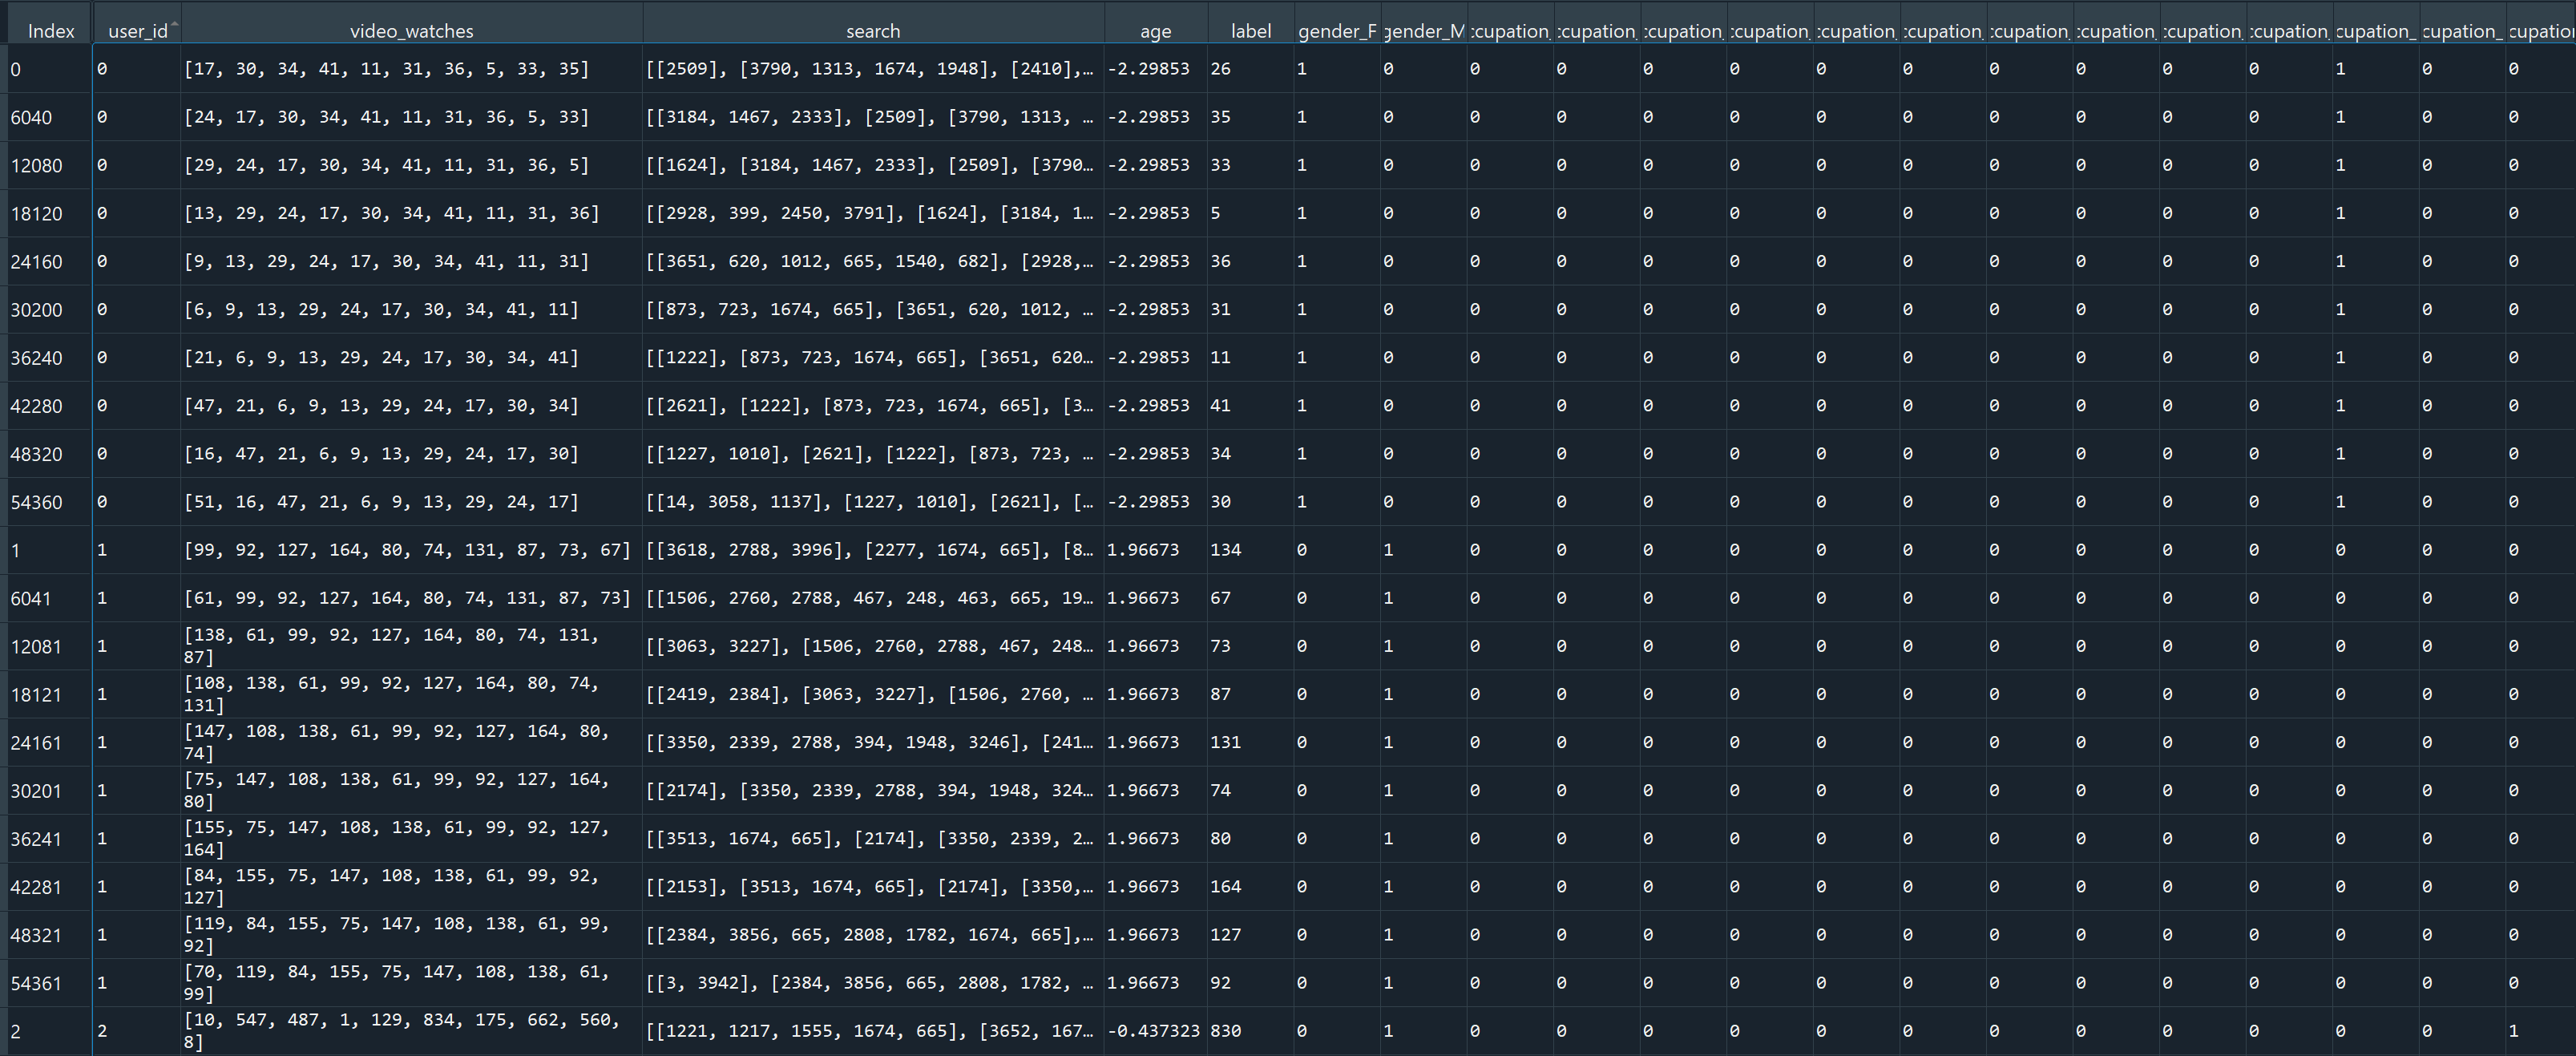

Flatten the lists in the "video_watches" and "search" columns.

In [13]:
# Flatten the data set and create a column in the data set counting the number of search tokens.

def extract_list_to_multiple_columns(dataset, column, max_len, padding):
  '''
  Sub-function used in prepare_train_val_test().
  Extract a column comprised of  lists (one list in one cell) to multiple column, one column for 
  one element in the list. And drop the original column.

  Arguments:
  -- dataset. Name of the dataset.
  -- column. Column name, in string form.
  -- max_len. An integer. The length of the list in each cell is varied. Limit the length to the max_len. Discard the
  rest.
  -- padding. Define what to pad to the cells whose length is less than max_len.

  Returns:
  -- The resulted data set.
  '''

  i = 0
  for i in range(max_len):
      dataset[column +'_' + str(i)] = dataset[column].apply(lambda x: x[i] if i < len(x) else padding)
  dataset.drop(column, axis = 1, inplace = True)
      
  return dataset


def get_token_count(dataset):
    ''' 
    Sub-function used in prepare_train_val_test().
    Count the number of tokens in the search token history.
    Add one column named 'token_count' to the original dataset.'''
    
    df = dataset.filter(regex = 'search')
    dataset['token_count'] = (df!=0).astype(int).sum(axis=1)
    
    return dataset


def flatten_df(dataset, max_token_len):
    '''
    Flatten the DataFrame. 
    
    Arguments:
    -- dataset: dataset.
    -- max_token_len: the fixed length of tokens for each search.
    
    Return:
    -- dataset: flattened dataset.'''
    
    
    dataset = extract_list_to_multiple_columns(dataset, 'video_watches', 10, padding = 0)   # padding = 0 because the movieID index starts from 1. In fact, no padding happened.
    dataset = extract_list_to_multiple_columns(dataset, 'search', 10, padding = [0])        # padding = 0 because the token index starts from 1. In fact, no padding happened.
       
    j = 0
    while j < 10:
        dataset = extract_list_to_multiple_columns(dataset, 'search_'+str(j), max_token_len, padding = 0)  # Discard tokens after max_token_len, and pad 0 to titles whose length is less than max_token_len.
        j += 1
        
    # create a column counting the number of search tokens
    dataset = get_token_count(dataset)   
    
    return dataset


grouped_final = flatten_df(grouped_final, max_token_len = 8)

print(grouped_final.shape)

(60400, 117)


The final set has 60,400 rows and 117 columns (What? We have 117 input features for the NN? The answer is NO, we will reduce it through embedding later). They are:


> User_id

> Age 

> Gender

> Occupation

> Video watches

> Search tokens

> Token count

> Label

"Age", "gender", "occupation", "video watches", "search tokens" are useful input features of the neural network. The "number of tokens" are helper information for the neural network. The final data set is like (only part of the columns are shown):


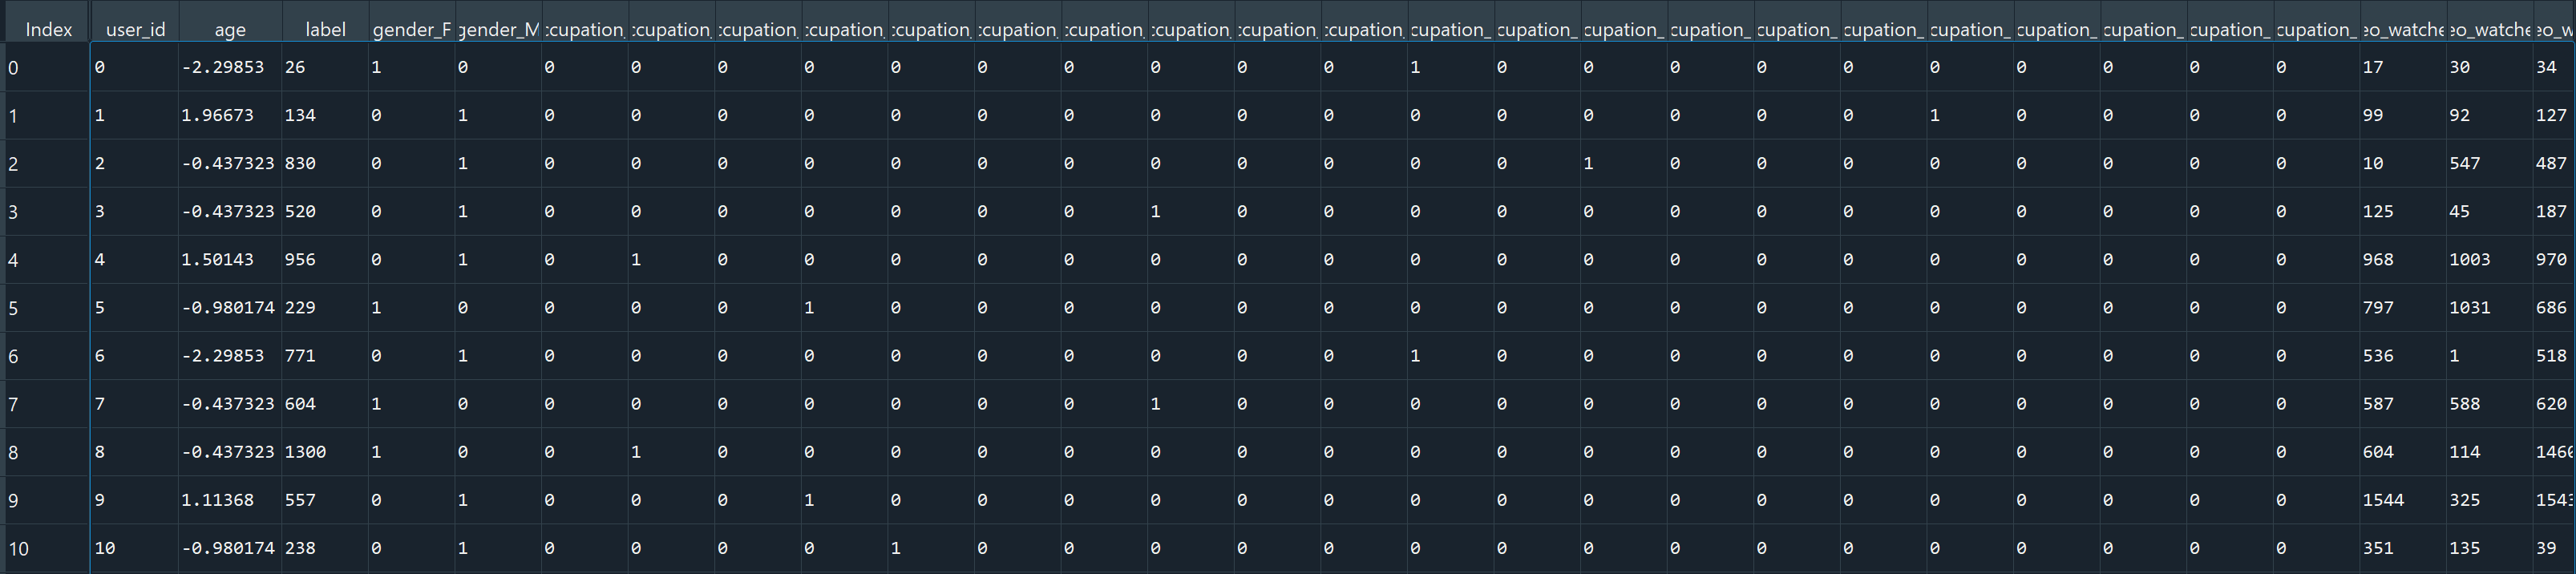
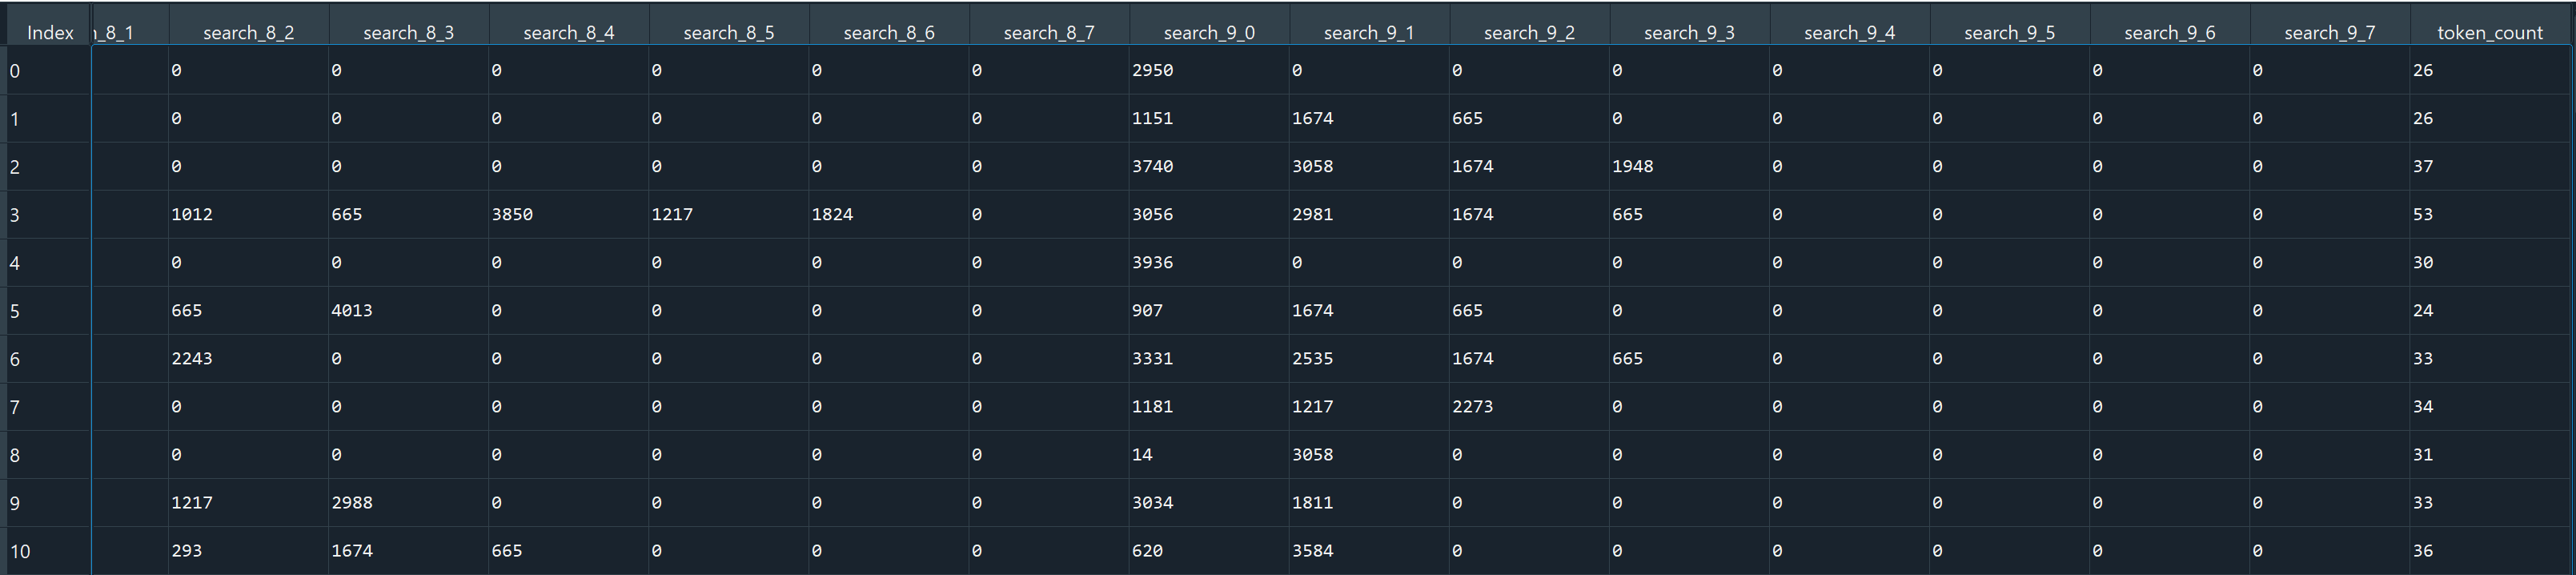

Take a 60-20-20% split on final data set, making sure all users are in all three. Average number of examples per user in the train, validation and test sets are 6, 2 and 2, respectively.

In [14]:
# split train, test and validation sets
train, test = train_test_split(grouped_final, test_size=.4, train_size=.6, random_state=574, stratify=grouped_final.loc[:,'user_id'])
val, test = train_test_split(test, test_size=.5, train_size=.5, random_state=999, stratify=test.loc[:,'user_id'])

In [15]:
print('The shape of train set:', train.shape)
print('The shape of validation set:', val.shape)
print('The shape of test set:', test.shape)

The shape of train set: (36240, 117)
The shape of validation set: (12080, 117)
The shape of test set: (12080, 117)


## 2.4 Constructing embedding matrix.

Now I construct the embedding matrix, the kth row indicating the embedding vector for the kth word in the vocabulary. In the neural network model building process, an word embedding layer with the same shape as the embedding matrix will be built, and its weights will be set to equal to the embedding matrix. 

There are 4,053 words in the vocabulary, 98 of which are not in GloVe. For words present in GloVe, I fill their Glove embedding values in the embedding matrix. For the words not present in GloVe, I assign a vector of small random numbers (from normal distribution of zero mean and *scale* variance, *scale* is a tuneable hyper-parameter) as its embedding values. At this stage, I also assign a vector of small random numbers to index 0 (but this vector is actually not used later).

I use Gensim library to efficiently load word embeddings .

In [16]:
# constructing embedding matrix

def get_embedding_dct(index_to_word, pretrained_emb_model, scale = .01):
    '''
    Get embedding dictionary. 
    The keys are index in the vocabulary and the values are pre-trained embedding values.
    If the keys are not present in the pretrained_emb_dct, random values of normal distribution(0, scale) are filled as embedding values.
    
    Arguments:
    -- index_to_word: a dictionary, e.g. {0: 'the', 1: 'multiple'}.
    -- pretrained_emb_dct: a dictionary of pre-trained word embeddings, e.g. {'the': (1D numpy array)}.
    -- scale: the scale of normal distribution.
    
    Output:
    -- emb_dct : a dictionary. 
                The keys are the indices of index_to_word and the values are the corresponding pre-trained 
                word embeddings, e.g. {0: (1D numpy array)}
    '''
    

    emb_dct = {}
    word_emb_dim = len(pretrained_emb_model['the'])
    for index, word in index_to_word.items():
        if word in pretrained_emb_model.vocab:
            emb_dct[index] = pretrained_emb_model[word]
        else:
            emb_dct[index] = np.random.normal(scale=scale, size=word_emb_dim)
        
    return emb_dct


def get_emb_matrix(emb_dct):
  '''
  Get embedding matrix for the words in the vocabulary. 
  The shape of the embedding matrix is (vocabulary size, embedding dimensions).

  Parameters
  ----------
  emb_dct : Dictionary.
      The keys are the indices of index_to_word and the values are the corresponding pre-trained word embeddings, e.g. {0: (1D numpy array)}

  Returns
  -------
  emb_matrix : Numpy matrix shaped (vocabulary size, embedding dimensions).
      Each row is the pre-trained word embedding values for a word in the vocabulary.

  '''
  voc_size = len(emb_dct)
  word_emb_dim = len(emb_dct[0])
  emb_matrix = np.zeros((voc_size, word_emb_dim))
  i = 0
  while i < voc_size:
      emb_matrix[i,:] = emb_dct[i]
      i += 1
      
  return emb_matrix

import gensim.downloader as api

GloVe_model = api.load("glove-wiki-gigaword-100") 

# construct embedding dictionary. 
emb_dct = get_embedding_dct(index_to_word, GloVe_model, scale = .01)

# get embedding matrix, which will be used as the word embedding layer in the neural network. 
emb_matrix = get_emb_matrix(emb_dct)

print(emb_matrix.shape)

[==================================================] 100.0% 128.1/128.1MB downloaded
(4054, 100)


# 3. Model building.

In [17]:
# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [24]:
# DataLoader
class MyDataset(Dataset):

    def __init__(self, data):
        """
        Args:
            data: the dataset, in pandas DataFrame form.
        """
        self.df = data

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        ''' Retrieve instance(s) from data.
        
        Argument:
            -- idx: an integer of a list of integers.
            
        return: 
            -- A tuple storing (X,y), where X is a tensor shape (2,) and y is an integer.
        '''

        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        video_watches = self.df.filter(regex = 'video_watches')
        video_watches = video_watches.iloc[idx, :]
        video_watches = torch.tensor(video_watches.values, dtype = torch.long)
        
        search_tokens = self.df.filter(regex = 'search')
        search_tokens = search_tokens.iloc[idx, :]
        search_tokens = torch.tensor(search_tokens.values, dtype = torch.long)
        
        context = self.df.iloc[idx, 1:25]
        context = torch.tensor(context.values)
        
        token_count = self.df.iloc[idx, self.df.columns == 'token_count']
        token_count = torch.tensor(token_count.values, dtype = torch.long)
        
        y = self.df.iloc[idx, self.df.columns == 'label']
        y = torch.tensor(y.values, dtype = torch.long)
        
        X = (video_watches, search_tokens, context, token_count)
        sample = (X, y)
        
        return sample

train_set = MyDataset(train)    
loader_train = DataLoader(train_set, batch_size=32, shuffle = True, num_workers = 0)  

val_set = MyDataset(val)    
loader_val = DataLoader(val_set, batch_size=32, shuffle = True, num_workers = 0)  

test_set = MyDataset(test)    
loader_test = DataLoader(test_set, batch_size=32, shuffle = True, num_workers = 0)  

## 3.1 Neural network structure.

In [19]:
def create_emb_layer(emb_matrix, word_emb_non_trainable = True):
    ''' 
    Create an embedding layer for the NN.
    
    Arguments:
    -- emb_matrix: A matrix shaped (voc_size, embedding_dim) storing the pre-trained word embeddings.
    -- word_emb_non_trainable: True or False. If True, do not train the pre-trained word embeddings.
    
    Returns:
    -- token_emb: Embedding layer used in NN.
    -- voc_size: Vocabulary size.
    -- embedding_dim: Number of embedding dimensions.
    '''
    
    voc_size, embedding_dim = emb_matrix.shape
    token_emb = nn.Embedding(voc_size, embedding_dim, padding_idx = 0)
    token_emb.weight.data.copy_(torch.from_numpy(emb_matrix))
    
    if word_emb_non_trainable:
        token_emb.weight.requires_grad = False

    return token_emb


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)

In [20]:
class CandidateGenerator(nn.Module):
    def __init__(self, num_of_movie, movie_user_emb_dim, emb_matrix, word_emb_non_trainable,
                 hidden_size1, hidden_size2, hidden_size3):
        super().__init__()
        word_emb_dim = emb_matrix.shape[1]
        input_dim = movie_user_emb_dim + word_emb_dim + 24
        self.movie_emb = nn.Embedding(num_of_movie, movie_user_emb_dim, padding_idx = 0) 
        self.token_emb = create_emb_layer(emb_matrix, word_emb_non_trainable)    # size (voc_size, embedding_dim)
        
        self.comb = nn.Sequential(
                        nn.Linear(input_dim, hidden_size1), 
                        nn.BatchNorm1d(hidden_size1),     # has learnable parameters gamma and beta                  
                        nn.ReLU(inplace = True),                        
                        
                        #nn.Dropout(p = 0.5),
                        nn.Linear(hidden_size1, hidden_size2), 
                        nn.BatchNorm1d(hidden_size2),                      
                        nn.ReLU(inplace = True),
                                                
                        #nn.Dropout(p = 0.5),
                        nn.Linear(hidden_size2, hidden_size3), 
                        nn.BatchNorm1d(hidden_size3),                      
                        nn.ReLU(inplace = True),
                                                
                        #nn.Dropout(p = 0.5),
                        nn.Linear(hidden_size3, movie_user_emb_dim)      
                    )
        
        #self.comb.apply(init_weights)

    def forward(self, X):       
        video_watches, search_tokens, context, token_count = X
        watches = self.movie_emb(video_watches)      # video_watches size: torch.Size([batch_size, max_hist_count]). 
                                                     # watches size: ([batch_size, max_hist_count, movie_user_emb_dim])
        watches = torch.sum(watches,1) / 10          # watches size: ([batch_size, movie_user_emb_dim])
        
        tokens = self.token_emb(search_tokens)       # search_tokens size: (batch_size, max_hist_len*max_token_len)
                                                     # tokens.size      ([batch_size, max_hist_len*max_token_len, word_emb_dim])
        tokens = torch.sum(tokens,1) / token_count   # tokens.size      ([batch_size, word_emb_dim])
        
        output = torch.cat((watches, tokens, context), 1)    # torch.Size([batch_size, 90])
        output = self.comb(output.float())
        
        return output                                # torch.Size([batch_size, movie_user_emb_dim])

## 3.2 Construct customized loss function.

The YouTube paper states:

"To eciently train such a model with millions of classes, we rely on a technique to sample negative classes from the background distribution and then correct for this sampling via importance weighting. For each example the cross-entropy loss is minimized for the true label and the sampled negative classes."

The equation of Nagative Sampling is:



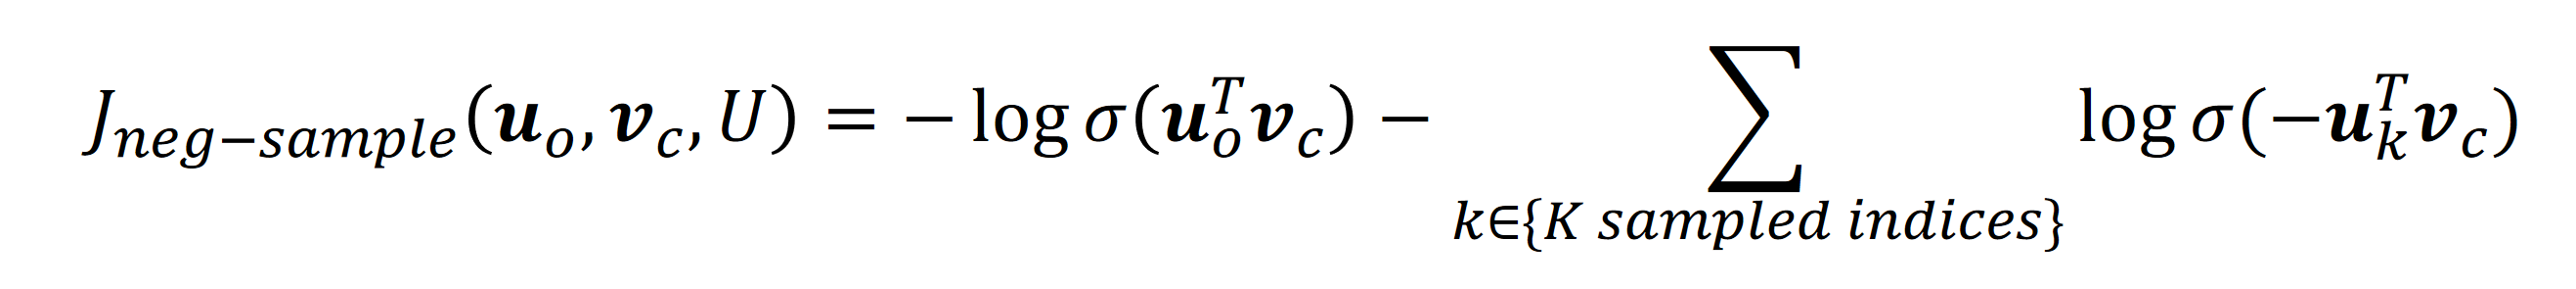
Source: http://web.stanford.edu/class/cs224n/slides/cs224n-2021-lecture02-wordvecs2.pdf

In this case I assume that each video are equally important, thus, no need to further apply importance weighting correction. I created the Negative Sampling loss function, which is not available in standard Python packages.

In [27]:
def sample_negative_labels(target_label_batch, k, num_of_movie):
    ''' 
    Given a true label, sample random k negative integers (labels) from low (inclusive) to high (exclusive).
    In this task, assume the movies are uniformly distributed.
    As a sub-function used in NegativeSamplingLoss().
    
    Arguments:
    -- target_label_batch: Torch tensor of size (batch_size, 1).
    -- k: An integer, 0 < k < m, where m is the total number of movies.
    -- num_of_movie: An integer.
           Max number to choose from (exclude).
    
    Returns:
    -- negative_labels: Torch tensor of size (batch_size, k).
          Each element in a row does not equal to value of the same row in the target_label_batch.'''
    
    batch_size, _ = target_label_batch.size()
    negative_labels = torch.randint(low = 1, high = num_of_movie, size = (batch_size, k))   # low = 1 means min number to choose from (include)
                                                                           # movieID starts from index 1. Index 0 is for padding.
    # to avoid sampling the true label.
    i = 0
    while i < batch_size:
        true_label = target_label_batch[i, 0]
        j = 0
        while j < k:
            while True:
                if negative_labels[i, j] == true_label:
                    negative_labels[i, j] = torch.randint(low = 1, high = num_of_movie, size = (1,))   # sample again
                else:
                    break
            j += 1    
        i += 1
    
    return negative_labels


def NegativeSamplingLoss(movie_emb_weight, y_pred, y, k, num_of_movie):
    
    ''' Compute the loss for a batch of user's vectors.
    For the loss for the true labels:
        First, map the movie embedding weights for the true labels as pos_movie_embeddings.
        Second, take the product of y_pred (user vectors) and pos_movie_embeddings (movie vectors).
        Third, take log and sigmoid.
        At last, take negative and sum up.
    Do the similar trick to sampled negative labels.
    
    Arguments:
    -- movie_emb_weight:
    -- y_pred: Torch tensor of size (batch_size, movie_user_emb_dim).
            It can be considered as a batch of user's vectors. It can be the forward pass output of CandidateGenerator.
    -- y: Torch tensor of size (batch_size, 1).
            A batch of true labels.
    -- k: An integer, 0 < k < m, where m is the total number of movies.
            Sample k negative labels.
    -- num_of_movie:  An integer.
           Number of movies. The maximum number to choose from (exclude) in generating negative samples.
        
    Returns:
    -- loss: A scalar.
          Average loss for each training example. '''
    
    batch_size, _ = y.size()  
                
    # compute loss of target label        
    pos_movie_embeddings = movie_emb_weight[y.squeeze(), :]   # torch.Size([batch_size, movie_user_emb_dim])
    pos_loss = (pos_movie_embeddings * y_pred).sum(dim=1)           # torch.Size([batch_size])
    pos_loss = torch.log(torch.sigmoid(pos_loss))                              # torch.Size([batch_size])
    pos_loss = -pos_loss.sum()                                                 # scalar tensor
    
    # compute loss of negative samples
    negative_labels = sample_negative_labels(y, k, num_of_movie)    # torch.Size([batch_size, k]).
    neg_movie_embeddings = F.embedding(negative_labels, movie_emb_weight)      # torch.Size([batch_size, k, movie_user_emb_dim]).
    y_pred = y_pred.unsqueeze(dim=1).expand(-1, k,-1)        # torch.Size([batch_size, k, movie_user_emb_dim])
    neg_loss = (neg_movie_embeddings * y_pred).sum(dim=2)    # torch.Size([batch_size, k])
    neg_loss = torch.log(torch.sigmoid(-neg_loss))           # torch.Size([batch_size, k])
    neg_loss = -neg_loss.sum()                               # scalar tensor
    
    loss = (pos_loss + neg_loss) / batch_size
    
    return loss

Test block for the loss function (optional).

In [28]:
# test loss function
# need to modify the code in NegativeSamplingLoss() before running this
# modify as: negative_labels = torch.tensor([[3, 1, 1],[2, 1, 4]])

def rel_error(x, y):
  """ returns relative error """
  return np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))


def init_toy_data():
    torch.manual_seed(989); y_pred = torch.normal(0,2,(2, 3))   # (batch_size = 2, movie_user_emb_dim = 3)
    torch.manual_seed(454); y = torch.randint(low=1, high=5, size=(2, 1))
    return y, y_pred

y, y_pred = init_toy_data()
k = 3
num_of_movie = 5
torch.manual_seed(263); movie_emb_weight = torch.randn((5, 3))   # size (num_of_movie = 5, movie_user_emb_dim) 
# need to modify the code in NegativeSamplingLoss() to set the value of negative_labels
negative_labels = torch.tensor([[3, 1, 1],[2, 1, 4]])

loss = NegativeSamplingLoss(movie_emb_weight, y_pred, y, k, num_of_movie)

print('My loss:')
print(loss)
print()
print('correct loss:')
correct_loss = torch.tensor(6.5436)
print(correct_loss)
print()

# The difference should be very small. We get < 1e-5
print('Difference between my loss and correct loss:')
print(rel_error(loss, correct_loss))

My loss:
tensor(6.5436)

correct loss:
tensor(6.5436)

Difference between my loss and correct loss:
tensor(2.6234e-06, dtype=torch.float64)


# 4. Model training.

In [26]:
num_of_movie = len(movieID_to_index)       # already included 0: $PAD$

# tuneable hyper-parameters
movie_user_emb_dim = 50   
hidden_size1 = 1024
hidden_size2 = 512
hidden_size3 = 256
k = 10

# need to compute the  number of parameters.

#%% training and experiments
model = CandidateGenerator(num_of_movie, movie_user_emb_dim, emb_matrix, word_emb_non_trainable=True,
                 hidden_size1=hidden_size1, hidden_size2=hidden_size2, hidden_size3=hidden_size3)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

max_epoch = 1

for epoch in range(max_epoch):  

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        model.train()     
        X, y = data

        # zero the parameter gradients before backprop, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the           # operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).
        optimizer.zero_grad()

        y_pred = model(X)  # we can treat it as user vectors
        
        # get the current movie embedding weights.
        for name, param in model.named_parameters():
            if name in ['movie_emb.weight']:
                movie_emb_weight = param.detach()      # torch.Size([num_of_movie, movie_user_emb_dim])
                
        loss = NegativeSamplingLoss(movie_emb_weight, y_pred, y, k, num_of_movie)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches.  We have 1,132 iterations each epoch.
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0


[1,    50] loss: 11.243
[1,   100] loss: 9.310
[1,   150] loss: 8.361
[1,   200] loss: 8.030
[1,   250] loss: 7.868
[1,   300] loss: 7.839
[1,   350] loss: 7.801
[1,   400] loss: 7.734
[1,   450] loss: 7.732
[1,   500] loss: 7.720
[1,   550] loss: 7.747
[1,   600] loss: 7.688
[1,   650] loss: 7.687
[1,   700] loss: 7.704
[1,   750] loss: 7.698
[1,   800] loss: 7.698
[1,   850] loss: 7.689
[1,   900] loss: 7.684
[1,   950] loss: 7.673
[1,  1000] loss: 7.664
[1,  1050] loss: 7.659
[1,  1100] loss: 7.679
